In [1]:
import numpy as np
import pandas as pd
import openturns as ot
from matplotlib import cm
import matplotlib.pyplot as plt
from bancs import DrawFunctions
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [2]:
from matplotlib import rc
rc('font', **{'family': 'Libertine'})
rc('text', usetex=True)
rc('text', usetex=True)
plt.rcParams.update({'text.latex.preamble': r'\usepackage{amsfonts}'})
rc('font', size=16)# Set the default text font size
rc('axes', titlesize=20)# Set the axes title font size
rc('axes', labelsize=16)# Set the axes labels font size
rc('xtick', labelsize=16)# Set the font size for x tick labels
rc('ytick', labelsize=16)# Set the font size for y tick labels
rc('legend', fontsize=16)# Set the legend font size

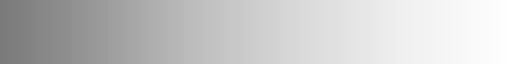

In [3]:
greys = mpl.colormaps['Greys_r']
faded_greys = ListedColormap(greys(np.linspace(0.4, 1, 128)))
faded_greys

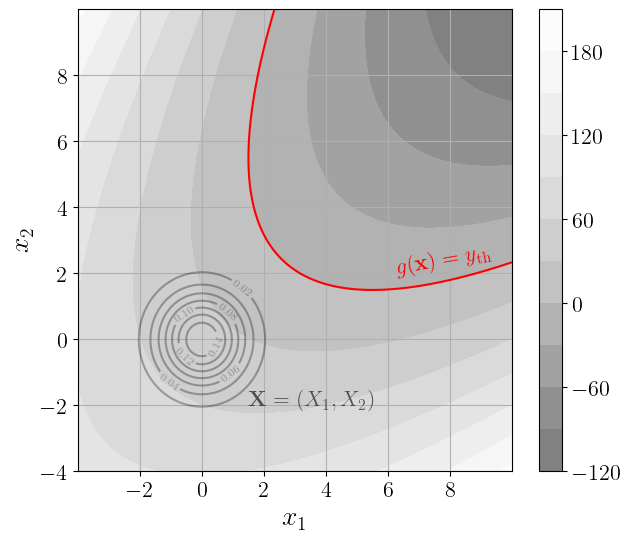

In [4]:
g = ot.SymbolicFunction(["x1", "x2"], ["(x1 - x2) ^ 2 - 8 * (x1 + x2 - 5)"])
X = ot.ComposedDistribution([ot.Normal(0., 1.)] * 2)
Y = ot.CompositeRandomVector(g, ot.RandomVector(X))
threshold = 0.
failure_event = ot.ThresholdEvent(Y, ot.LessOrEqual(), threshold)

d = DrawFunctions()
d.set_bounds([-4] * 2, [10] * 2)
d.draw_2D_controur(title="", function=g, distribution=X, colorbar=faded_greys)
contour = plt.contour(d.X0, d.X1, d.Z, levels=[threshold], colors='red')
#plt.clabel(contour, inline=True, fontsize=12, colors='k')
plt.text(1.5, -2, "$\\mathbf{X} = (X_1, X_2)$", fontsize=16, alpha=0.6)
plt.text(6.2, 2., "$g(\\mathbf{x}) = y_{\mathrm{th}}$", fontsize=16, color='red', rotation=10)
plt.grid()
plt.xticks(range(-2, 10, 2))
plt.yticks(range(-4, 10, 2))
plt.savefig("figures/parabolic_problem.jpg", dpi=300, bbox_inches='tight');

## Crude Monte Carlo

In [5]:
N = int(1e5)
x_mc = np.array(X.getSample(N))
y_mc = np.array(g(x_mc))
mc_sample = np.concatenate([x_mc, y_mc], axis=1)
x_failed = mc_sample[y_mc.flatten() <= 0, :-1]

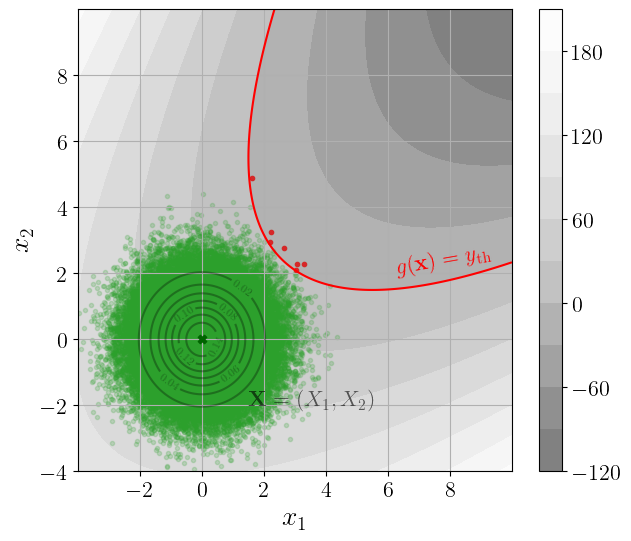

In [6]:
d = DrawFunctions()
d.set_bounds([-4] * 2, [10] * 2)
d.draw_2D_controur(title=None, function=g, distribution=X, colorbar=faded_greys)
contour = plt.contour(d.X0, d.X1, d.Z, levels=[threshold], colors='red')
#plt.clabel(contour, inline=True, fontsize=12, colors='k')
plt.scatter(x_mc[:, 0], x_mc[:, 1], color='C2', marker='.', alpha=0.2)
plt.scatter(x_failed[:, 0], x_failed[:, 1], color='C3', marker='.')
plt.scatter(0, 0, color='darkgreen', marker='X', zorder=3)

plt.xlim(-4, 10)
plt.ylim(-4, 10)
plt.xticks(range(-2, 10, 2))
plt.yticks(range(-4, 10, 2))
plt.text(1.5, -2, "$\\mathbf{X} = (X_1, X_2)$", fontsize=16, alpha=0.6)
plt.text(6.2, 2., "$g(\\mathbf{x}) = y_{\mathrm{th}}$", fontsize=16, color='red', rotation=10)
plt.grid()

plt.savefig("figures/reliability_MC_illustration.png", dpi=300, bbox_inches='tight');

## FORM / SORM

In [7]:
algo = ot.FORM(ot.Cobyla(), failure_event, X.getMean())
algo.run()
result = algo.getResult()
standardSpaceDesignPoint = result.getStandardSpaceDesignPoint()

## Importance sampling

In [8]:
X_is  = ot.Normal(2)
X_is.setMean(standardSpaceDesignPoint)

x_mc = np.array(X_is.getSample(N))
y_mc = np.array(g(x_mc))
mc_sample = np.concatenate([x_mc, y_mc], axis=1)
x_failed = mc_sample[y_mc.flatten() <= 0, :-1]

<Figure size 300x300 with 0 Axes>

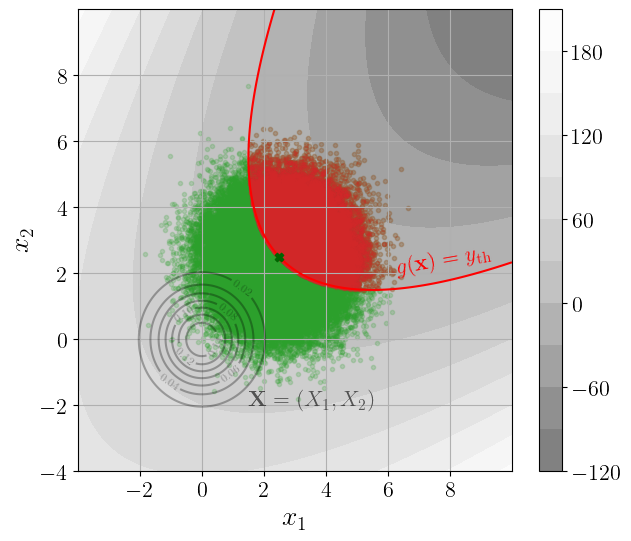

In [9]:
plt.figure(figsize=(3,3))
d = DrawFunctions()
d.set_bounds([-4] * 2, [10] * 2)
d.draw_2D_controur(title=None, function=g, distribution=X, colorbar=faded_greys)
contour = plt.contour(d.X0, d.X1, d.Z, levels=[threshold], colors='red')
#plt.clabel(contour, inline=True, fontsize=12, colors='k')
plt.scatter(x_mc[:, 0], x_mc[:, 1], color='C2', marker='.', alpha=0.2)
plt.scatter(x_failed[:, 0], x_failed[:, 1], color='C3', marker='.', alpha=0.2)
plt.scatter(standardSpaceDesignPoint[0], standardSpaceDesignPoint[1], color='darkgreen', marker='X', zorder=3)

plt.xlim(-4, 10)
plt.ylim(-4, 10)
plt.xticks(range(-2, 10, 2))
plt.yticks(range(-4, 10, 2))
plt.text(1.5, -2, "$\\mathbf{X} = (X_1, X_2)$", fontsize=16, alpha=0.6)
plt.text(6.2, 2., "$g(\\mathbf{x}) = y_{\mathrm{th}}$", fontsize=16, color='red', rotation=10)
plt.grid()
plt.savefig("figures/reliability_IS_illustration.png", dpi=300, bbox_inches='tight');

## Subset sampling

In [10]:
N

100000

In [11]:
# Reliability problem
g = ot.MemoizeFunction(g)
Y = ot.CompositeRandomVector(g, ot.RandomVector(X))
failure_event = ot.ThresholdEvent(Y, ot.LessOrEqual(), threshold)
# Subset simulation setup 
algo = ot.SubsetSampling(failure_event)
algo.setMaximumOuterSampling(int(1e4))
algo.setKeepEventSample(True)
algo.run()
result = algo.getResult()
levels = algo.getThresholdPerStep()

In [12]:
input_subsets_samples = np.array(g.getInputHistory())
output_subsets_samples = np.array(g.getOutputHistory())
N = algo.getMaximumOuterSampling() * algo.getBlockSize()
nb_subset = algo.getStepsNumber()
N_total = result.getOuterSampling()

In [13]:
subset_indexes = np.repeat((np.arange(nb_subset)), N).reshape(-1, 1)
df_ss = pd.DataFrame(np.concatenate((subset_indexes, input_subsets_samples, output_subsets_samples), axis=1))
df_ss.columns = ["Subset"] + list(X.getDescription()) + ["Y"]

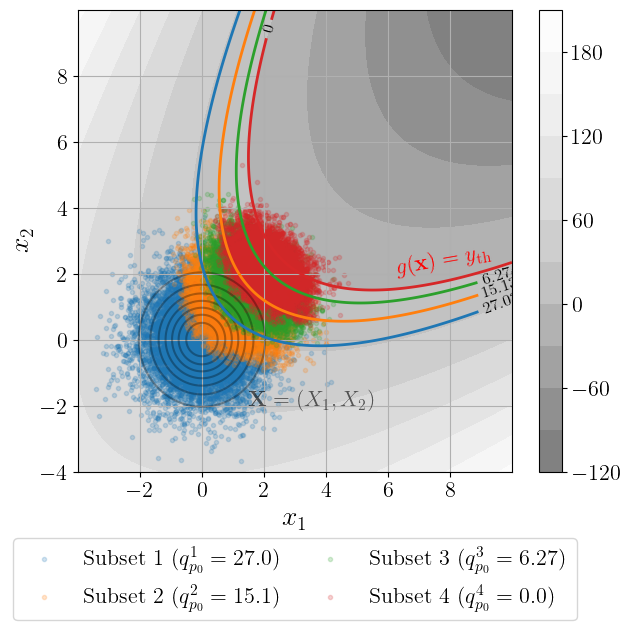

In [14]:
d = DrawFunctions()
d.set_bounds([-4] * 2, [10] * 2)
d.draw_2D_controur(title=None, function=g, distribution=X, colorbar=faded_greys, contour_values=False)
for i in range(nb_subset):
    ssample = df_ss[(df_ss["Subset"]==i) ]
    x0 = ssample["X0"].values
    x1 = ssample["X1"].values
    sslabel = "Subset {} ($q_{{p_0}}^{} = {:.3}$)".format(i+1, i+1, levels[i])
    sslabel = "Subset {} ($q_{{p_0}}^{} = {:.3}$)".format(i+1, i+1, levels[i])
    plt.scatter(x0, x1, color='C{}'.format(i), marker='.', alpha=0.2, label=sslabel)
    contour = plt.contour(d.X0, d.X1, d.Z, levels=[levels[i]], colors='C{}'.format(i), linewidths=2, linestyles=['solid'])
    plt.clabel(contour, inline=True, fontsize=12, colors='k')
plt.xlim(-4, 10)
plt.ylim(-4, 10)
plt.xticks(range(-2, 10, 2))
plt.yticks(range(-4, 10, 2))
plt.text(1.5, -2, "$\\mathbf{X} = (X_1, X_2)$", fontsize=16, alpha=0.6)
plt.text(6.2, 2., "$g(\\mathbf{x}) = y_{\mathrm{th}}$", fontsize=16, color='red', rotation=10)
plt.grid()

plt.legend(bbox_to_anchor=(0.5, -0.12), loc='upper center', ncol=2, columnspacing=1.2)
#plt.savefig("figures/subset_4branch.pdf", bbox_inches='tight')
plt.savefig("figures/reliability_SS_illustration.png", bbox_inches='tight', dpi=300);